In [233]:
import torch
from torch.utils.data import Dataset, DataLoaderç
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
import random
from PIL import Image
import PIL
import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn import metrics
import itertools

In [234]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [235]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [236]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2).cuda()
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [269]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.BatchNorm1d(8*100*100),
            nn.Dropout(.5),
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.BatchNorm1d(500),
            nn.Dropout(.3),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )
        
    def test_forward(self, inp):
        output = self.cnn1(inp)
        output = output.view(output.size()[0], -1)
        return output

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [283]:
BATCH_SIZE = 32
LEARNING_RATE = 0.0003
NUM_EPOCH = 500
PRINT_EVERY = 20
# ARCHITECTURE = 'resnet50'

In [295]:
net = torch.nn.DataParallel(SiameseNetwork()).cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE)

trfm_valid = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.CenterCrop((100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

trfm_train = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.CenterCrop((100)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor(),
])


train_set = datasets.ImageFolder("dataset/train/att")
train_data_set = SiameseNetworkDataset(train_set, transform=trfm_train)
train_dataloader = DataLoader(train_data_set, batch_size=BATCH_SIZE, shuffle=True)

valid_set = datasets.ImageFolder("dataset/valid/att")
valid_data_set = SiameseNetworkDataset(valid_set, transform=trfm_valid)
valid_loader = DataLoader(valid_data_set, batch_size=BATCH_SIZE, shuffle=False)

tensor([0.])


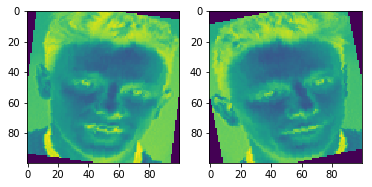

In [314]:
x,y,z = train_data_set.__getitem__(0)
fig, ax = plt.subplots(ncols=2,nrows=1)
ax[0].imshow(x.squeeze())
ax[1].imshow(y.squeeze())
print(z)

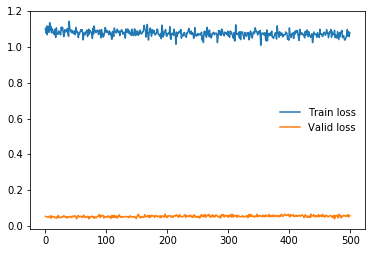

In [286]:
counter = []
loss_history = []
valid_loss_history = []



for epoch in range(NUM_EPOCH):
    progress = tqdm(enumerate(train_dataloader), desc='Epoch, loss: ')
    test_loss = 0
    train_loss = 0
    for i, data in progress:
        net.train()
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net.forward(img0,img1)
        
        loss_contrastive = criterion(output1,output2,label)
        train_loss += loss_contrastive.item()
        
        optimizer.zero_grad()
        loss_contrastive.backward()
        optimizer.step()
        progress.set_description(f"Epoch {epoch+1}/{NUM_EPOCH}, loss: {loss_contrastive.item():.3f}")
        
    net.eval()
    with torch.no_grad():
        for counter, (timgs1, timgs2, tlabels) in enumerate(valid_loader, 1):
                timgs1, timgs2, tlabels = timgs1.to(device), timgs2.to(device), tlabels.to(device)
                toimgs1, toimgs2 = net.forward(timgs1, timgs2)
                batch_loss = criterion(toimgs1, toimgs2, tlabels)
                test_loss += batch_loss.item()
    loss_history.append(train_loss/len(train_dataloader))
    valid_loss_history.append(test_loss/len(valid_dataloader))
plt.plot(loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)
plt.show()

In [325]:
def rounding(val, threshold=0.5):
    return 1 if val > threshold else 0

In [324]:
net.eval()
labels = []
preds = []
progress = tqdm(enumerate(valid_loader, 1))
len_valid = len(valid_loader)
with torch.no_grad():
    for idx, (img1,img2,label) in progress:
        progress.set_description(f'{idx}/{len_valid}')
        img1 = img1.to(device)
        img2 = img2.to(device)
        out1, out2 = net.forward(img1,img2)
        predicted_label = F.pairwise_distance(out1, out2)
#         print(predicted_label)
        rounded = list(map(rounding, predicted_label))
        preds.append(rounded)
        labels.append(list(map(int, label.view(-1))))
    
y_true = np.array(list(itertools.chain(*labels)))
y_pred = np.array(list(itertools.chain(*preds)))
tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
total = tn+tp+fp+fn
print(f'Predicted true and actually true: {tp}'
      f'\nPredicted false and actually false: {tn}'
      f'\nPredicted true but actually false: {fp}'
      f'\nPredicted false but actually true: {fn}'
      f'\nTotal correct predictions: {tp+tn} ({(tp+tn)/total*100:.2f}%)'
      f'\nTotal wrong predictions: {fn+fp} ({(fn+fp)/total*100:.2f}%)'
      f'\nTotal: ({total})')

Predicted true and actually true: 0
Predicted false and actually false: 66
Predicted true but actually false: 0
Predicted false but actually true: 54
Total correct predictions: 66 (55.00%)
Total wrong predictions: 54 (45.00%)
Total: (120)


In [289]:
test_set = datasets.ImageFolder("dataset/valid/yale")
test_data_set = SiameseNetworkDataset(test_set, transform=trfm)
test_loader = DataLoader(test_data_set, batch_size=20, shuffle=False)

In [290]:
net.eval()
labels = []
preds = []
progress = tqdm(enumerate(test_loader, 1))
len_valid = len(test_loader)
with torch.no_grad():
    for idx, (img1,img2,label) in progress:
        progress.set_description(f'{idx}/{len_valid}')
        img1 = img1.to(device)
        img2 = img2.to(device)
        out1, out2 = net.forward(img1,img2)
        predicted_label = F.pairwise_distance(out1, out2)
        rounded = list(map(rounding, predicted_label))
        preds.append(rounded)
        labels.append(list(map(int, label.view(-1))))
    
y_true = np.array(list(itertools.chain(*labels)))
y_pred = np.array(list(itertools.chain(*preds)))
tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
total = tn+tp+fp+fn
print(f'Predicted true and actually true: {tp}'
      f'\nPredicted false and actually false: {tn}'
      f'\nPredicted true but actually false: {fp}'
      f'\nPredicted false but actually true: {fn}'
      f'\nTotal correct predictions: {tp+tn} ({(tp+tn)/total*100:.2f}%)'
      f'\nTotal wrong predictions: {fn+fp} ({(fn+fp)/total*100:.2f}%)'
      f'\nTotal: ({total})')

Predicted true and actually true: 245
Predicted false and actually false: 127
Predicted true but actually false: 201
Predicted false but actually true: 73
Total correct predictions: 372 (57.59%)
Total wrong predictions: 274 (42.41%)
Total: (646)
